In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

In [18]:
def clean_and_analyze_data(df, dataset_name):
    print(f"\n========== {dataset_name} DATASET ==========")

    print("Initial Shape:", df.shape)

    print("\nNull values before cleaning:")
    print(df.isnull().sum())

    df = df.dropna()
    print("\nShape after removing null values:", df.shape)

    dup_rows = df.duplicated().sum()
    print("\nDuplicate rows found:", dup_rows)

    df = df.drop_duplicates()
    print("Shape after removing duplicate rows:", df.shape)

    dup_cols = df.columns[df.columns.duplicated()]
    print("\nDuplicate columns:", list(dup_cols))

    df = df.loc[:, ~df.columns.duplicated()]

    print("\nFinal Dataset Info:")
    print(df.info())

    return df

In [19]:
day_df = pd.read_csv("day.csv")
day_df = clean_and_analyze_data(day_df, "DAY")


========== DAY DATASET ==========
Initial Shape: (731, 16)

Null values before cleaning:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Shape after removing null values: (731, 16)

Duplicate rows found: 0
Shape after removing duplicate rows: (731, 16)

Duplicate columns: []

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   w

In [20]:
X = day_df.drop(columns=['instant', 'casual', 'registered', 'yr', 'dteday'])
y = day_df['cnt']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [23]:
param_grid = {
    'n_estimators': [5, 7, 15],
    'max_depth': [2, 2, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

In [24]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [25]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 2, 4], 'n_estimators': [5, 7, 15],
                         'subsample': [0.7, 1]},
             scoring='r2', verbose=1)

In [26]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 15, 'subsample': 1}
Best CV R² Score: 0.9483773657557151


In [27]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nDAY DATASET - XGBOOST PERFORMANCE AFTER TUNING")
print(f"Training R² Score : {train_r2:.4f}")
print(f"Training RMSE     : {train_rmse:.2f}")
print(f"Test R² Score     : {test_r2:.4f}")
print(f"Test RMSE         : {test_rmse:.2f}")
print(f"Test MAE          : {test_mae:.2f}")


DAY DATASET - XGBOOST PERFORMANCE AFTER TUNING
Training R² Score : 0.9516
Training RMSE     : 421.30
Test R² Score     : 0.9513
Test RMSE         : 441.89
Test MAE          : 364.90


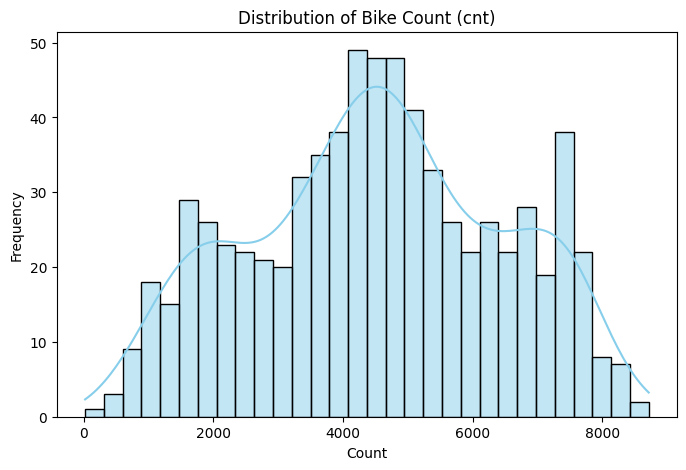

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
sns.histplot(day_df['cnt'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Bike Count (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

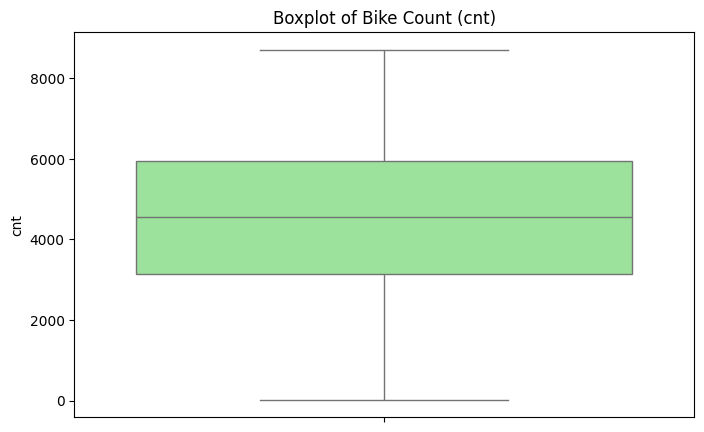

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=day_df['cnt'], color='lightgreen')
plt.title("Boxplot of Bike Count (cnt)")
plt.show()


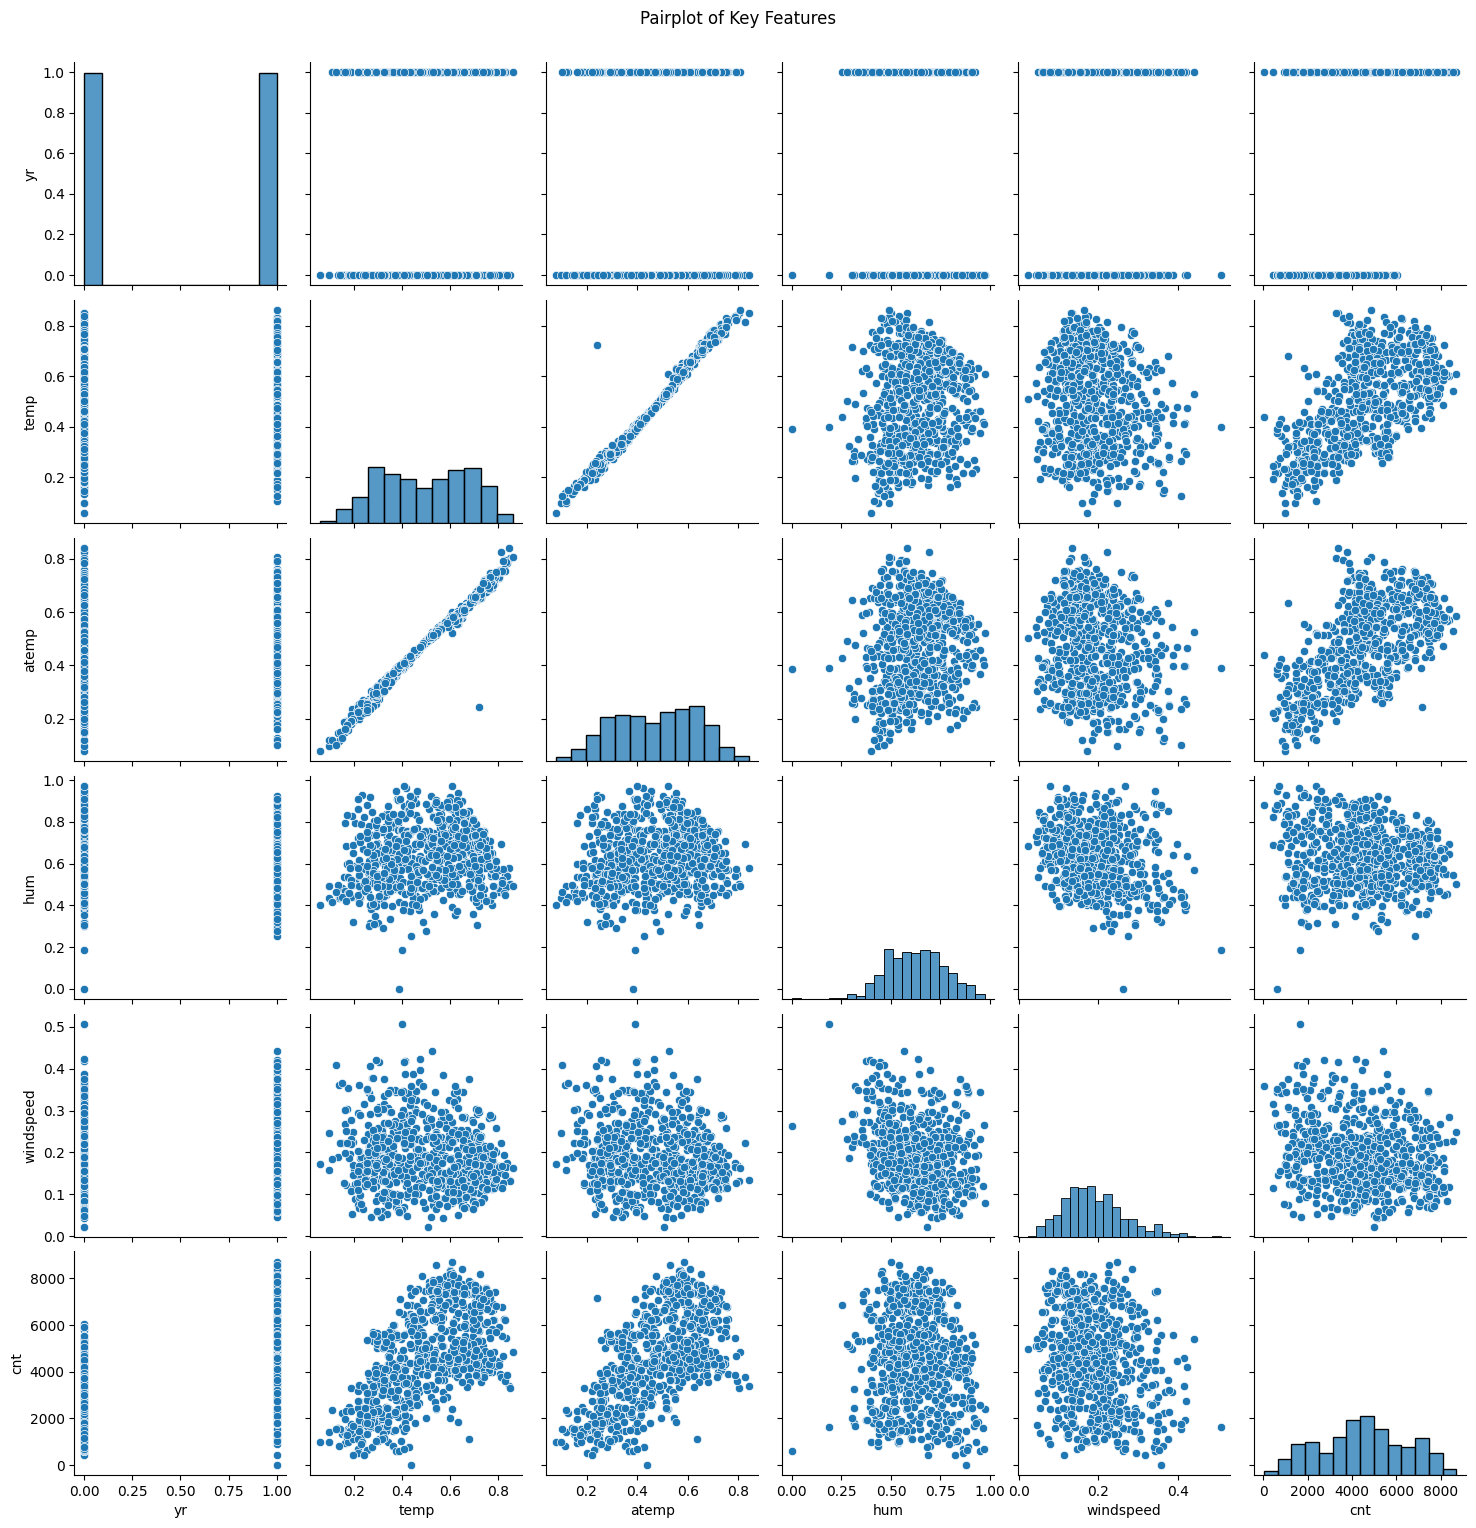

In [30]:
features = ['yr', 'temp', 'atemp', 'hum', 'windspeed','cnt']
sns.pairplot(day_df[features])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()